# Pytorch Workflow

In [1]:
what_were_covering = {1: "data (prepare and load)",
                     2: "build model",
                     3: "fitting the model to the data (training)",
                     4: "making prediction and evaluating a model (inference)",
                     5: "save and load the model",
                     6: "put it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to the data (training)',
 4: 'making prediction and evaluating a model (inference)',
 5: 'save and load the model',
 6: 'put it all together'}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.0'

## 1. Data (preparing and loading)

ML is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create some data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and testing sets (one of the most important concepts in ML in general)

Let's create a training and testing sets with our data

In [4]:
# Create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [9]:
# Plots training data, test data, and compares with predictions
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

    # Plot testing data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

    # Check predictions
    if predictions is not None:
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legends
    plt.legend(prop={"size": 14});

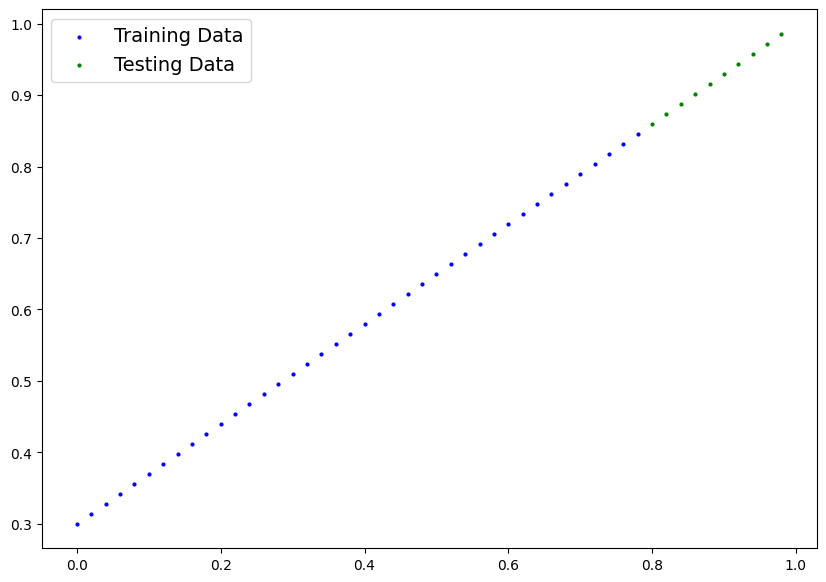

In [6]:
plot_predictions();

## 2. Building First PyTorch Model

Because we are going to be building classes throughout the course, getting familiar with OOP is important
* https://realpython.com/python3-object-oriented-programming/

What our model does:
* Start with random values (weight and bias)
* Look at training data and adjust random values to better represent (or get closer to) the ideal values (the weight and bias values we used to create the data)

It does this through 2 main algorithms:
1. Gradient descent
2. Backpropagation

In [7]:
from torch import nn

# Create a linear regression model class

class LinearRegressionModel(nn.Module): # <-- almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()

        # Initialize model parameters
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # 'x' is the input data
        return self.weights * x + self.bias # this is the linear regression formula        

### PyTorch model building essentials

* torch.nn - contains all the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - all nn.Module subclasses require this to overwrite forward(), this method defines what happens in the forward computation

Extra stuff
* https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of our PyTorch model

Now we've created a model, lets see whats inside

So we can check our model parameters, or whats inside our model using `.parameters()`.

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model we've created (sublcass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making Predictions using `torch.inference_mode()`

To check out model's predictive power, let's see how well it predicts `y_test` based on `X_test`

When we pass data through our model, its going to run it through the forward method

In [10]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

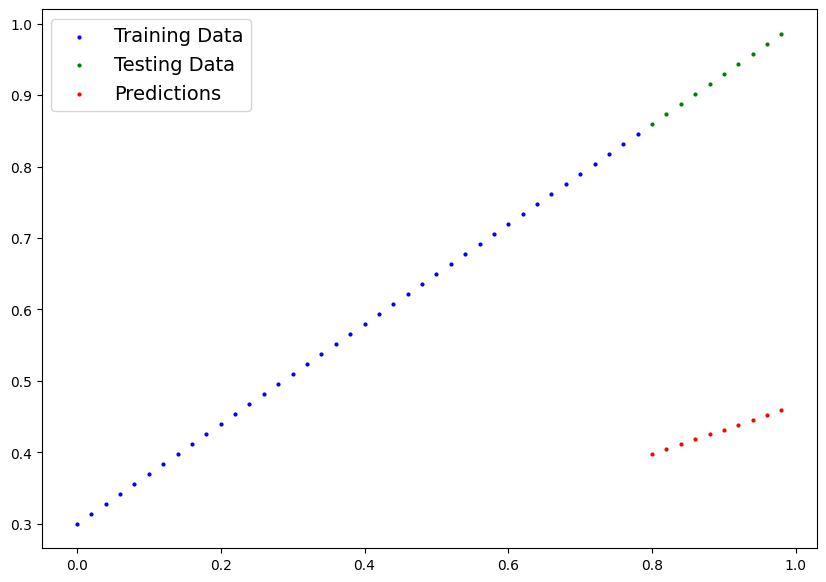

In [11]:
plot_predictions(predictions=y_preds)

## 3. Train Model

The whole idea of training is for the model to move from some *unknown* parameters (these may be random) to some *known* parameters

Or in some other words, from a poor representation of the data to a better representation

One way to measure how poor or wrong the model's predictions are is to use a loss function

Things we need to train:
* **Lost function:** a function to measure how wrong the model's predictions are to the ideal output, lower is better
* **Optimizer:** takes into account the loss of a model and adjust the model's parameters (eg weight and bias) to improve the loss function
    * 2 parameters need to be set in the optimizer
        * `params`: the model parameters that need to be optimized
        * `lr` (learning rate): the learning rate is a hyperparamter that defines how big/small the optimizer changes the parameters with each step

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [12]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
# Checks out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [14]:
# Set up a loss function
loss_fn = nn.L1Loss() # Mean Absolute Error loss function 

# Set up an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### Building a training loop (and a testing loop) in PyTorch

Things we need in a training loop:

0. Loop through the data and do...
1. Foward pass to make the predictions on data (this involves data moving through the `forward()` functions) - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizers zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameter of our model with the respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [15]:
# An epoch is one loop through the data... (this is a hyperparameter because we set it ourselves)
epochs = 200

# Track different values so they can be compared to future experiments with different hyperparameters
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range (epochs):
    # Set the model to training mode
    model_0.train() # Train mode in pytorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform back propagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Perform gradient descent
    optimizer.step() # by default how the optimizer changes will accumulate through the loop so we have to zero them above in step 3 for the next iteration of the loop

    ### Testing
    model_0.eval() # Turns off gradient tracking
    
    with torch.inference_mode(): # Turns off gradient tracking and some other things
        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # Print out what is happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
        
        # Print out model state dict
        print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

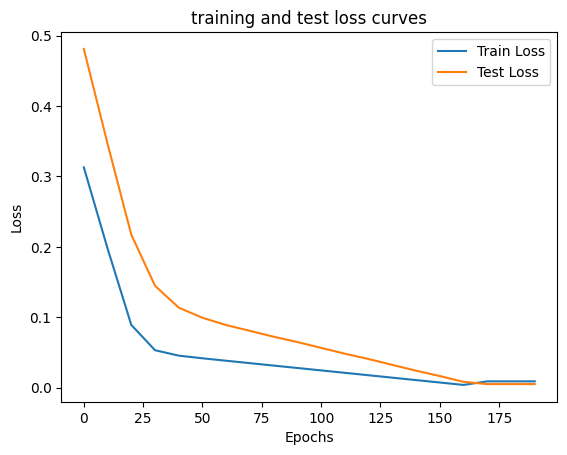

In [16]:
import numpy as np

# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [17]:
with torch.inference_mode():
    y_pred_new = model_0(X_test)

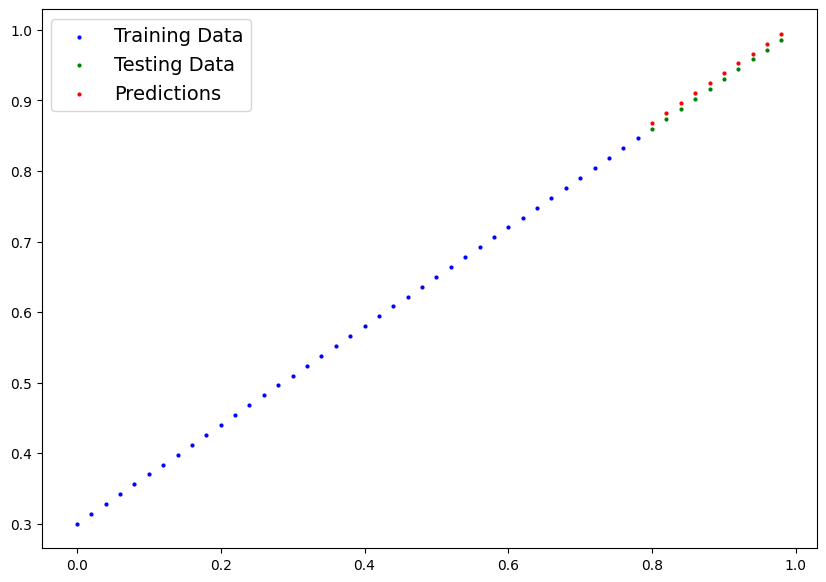

In [18]:
plot_predictions(predictions=y_pred_new)

## Saving a model in PyTorch

There are 3 main methods for saving and loading models in PyTorch:
1. `torch.save()` - save a PyTorch object in python's pickle format
2. `torch.load()` - allow you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows you to load a model's saved state dictionary

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [19]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create model path directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that

In [20]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [21]:
# To load in a saved state_dict() we have to instanciate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# To load the saved state_dict() of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [22]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [23]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [24]:
# Compare loaded_model_preds and y_preds
y_pred_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go through all the steps above and put it in one place.

In [1]:
# Importing PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

Create device-agnostic code.

This means if we have access to GPU, our code will use it (for potentially faster computational time). If no GPU is available, our device will default to CPU.

In [2]:
# Set up device-agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using Device: {device}")

Using Device: mps


### 6.1 Data

In [3]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze errors will pop up
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
# Split the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test)

(40, 10)

In [5]:
# Plots training data, test data, and compares with predictions
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

    # Plot testing data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

    # Check predictions
    if predictions is not None:
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legends
    plt.legend(prop={"size": 14});

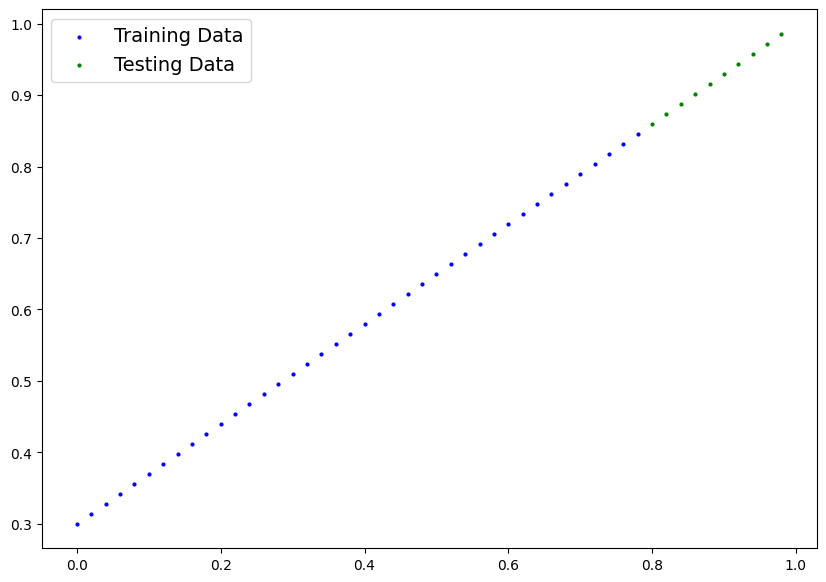

In [6]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear Model

In [7]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [9]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [11]:
# Set the model to use target device
model_1.to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [16]:
# Set up loss function
loss_fn = nn.L1Loss() # same as MAE

# Set up optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [17]:
# Writing a training loop
torch.manual_seed(42)

epochs = 200

# Device agnostic code for data
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero the optimizer
    optimizer.zero_grad()

    # 4. Perform backpropagation
    loss.backward()

    # 5. Perform gradient descent
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)

        test_loss = loss_fn(test_pred, y_test)

    # Print out whats happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779270172119 | Test Loss: 0.5739762783050537
Epoch: 10 | Loss: 0.4399681091308594 | Test Loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test Loss: 0.16984672844409943
Epoch: 40 | Loss: 0.09433844685554504 | Test Loss: 0.03513689711689949
Epoch: 50 | Loss: 0.023886388167738914 | Test Loss: 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739 | Test Loss: 0.04580312594771385
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.0375305712223053
Epoch: 80 | Loss: 0.01308917161077261 | Test Loss: 0.029944902285933495
Epoch: 90 | Loss: 0.009653176181018353 | Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.0062156799249351025 | Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645028764382005 | Test Loss: 0.013801807537674904
Epoch: 130 | Loss: 0.0012645028764382005 | Test Loss: 0.013801807537674

In [18]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='mps:0')),
             ('linear_layer.bias', tensor([0.3025], device='mps:0'))])

### 6.4 Making and evaluating predictions

In [19]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on test data
with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='mps:0')

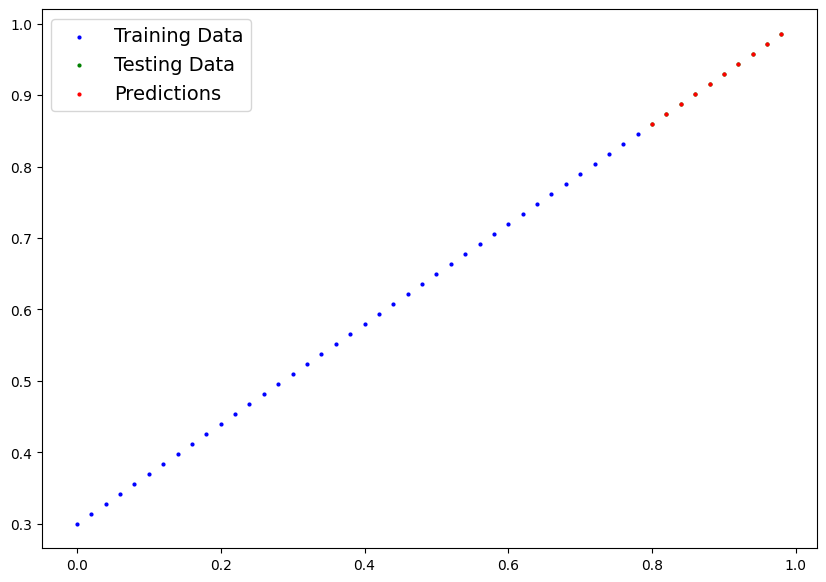

In [22]:
# Check out model predictions visually
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and loading a model